# Convective Rainfall Rate (CRR)

This notebook loads, inspects, and visualises NWC SAF Convective Rainfall Rate (CRR) retrievals from MSG over the African domain.  
The CRR product provides an **instantaneous convective rainfall rate**, stored as a scaled integer field (`crr_intensity`) and converted to physical units (**mm h⁻¹**) using the associated `scale_factor` and `add_offset`.  
Geolocation is provided on the native MSG grid via two-dimensional latitude and longitude fields.

CRR files are organised by date and follow the naming convention  
`S_NWC_CRR_MSG3_Africa-VISIR_YYYYMMDDTHHMMSSZ.nc`,  
where the timestamp corresponds to the nominal product time of the retrieval.  
The notebook constructs file paths from a given valid time and applies the appropriate scaling to recover the physical rain-rate field.


In [1]:
import numpy as np 
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import cartopy.crs as ccrs                              
import cartopy.feature as cfeature                   
import cartopy.io.shapereader as shpreader

import warnings
warnings.filterwarnings("ignore")

--------------------------------------------------------------------------
detected:

  Local host:            host839
  Device name:           mlx5_bond_0
  Device vendor ID:      0x02c9
  Device vendor part ID: 4127

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           host839
  Local device:         mlx5_bond_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
-------

example of filename: S_NWC_CRR_MSG3_Africa-VISIR_20240229T220000Z.nc

In [2]:
path_CRR = "/gws/ssde/j25b/swift/WISER-EWSA/Leeds_CRR/data"

year = "2024"
month = "02"
day = "29"
hour = "22"
minute = "00"

t = datetime(
    int(year), int(month), int(day),
    int(hour), int(minute)
)

date_str = t.strftime("%Y%m%d")

file_path = (
    f"{path_CRR}/{date_str}/CRR/"
    f"S_NWC_CRR_MSG3_Africa-VISIR_"
    f"{t:%Y%m%dT%H%M}00Z.nc"
)

In [3]:
ds = Dataset(file_path, mode="r")

In [4]:
var = ds.variables["crr_intensity"]
print(var.scale_factor, var.add_offset, var.units)

0.1 0.0 mm/h


In [5]:
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]

var = ds.variables["crr_intensity"]
crr_raw = var[:]

crr = crr_raw * var.scale_factor + var.add_offset

# Check domain extent

In [6]:
print(lat.min(), lat.max())
print(lon.min(), lon.max())
print(crr.min(), crr.max())

-45.522163 45.462624
-45.880703 81.21688
0.0 5.0


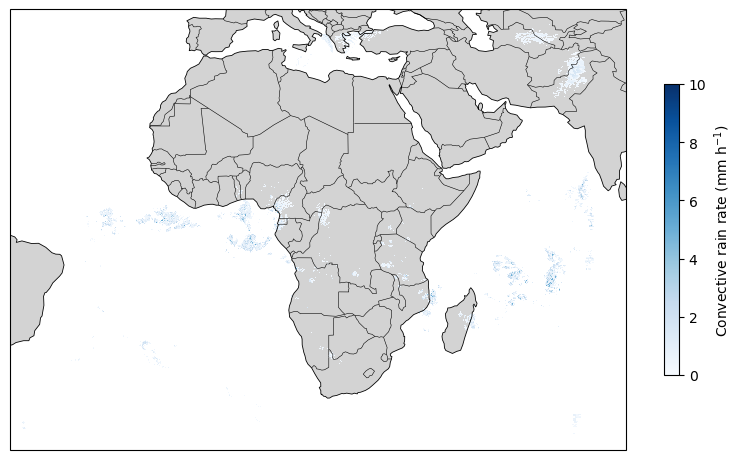

In [7]:
crr_plot = np.ma.masked_less(crr, 0.2)

fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(
    [lon.min(), lon.max(), lat.min(), lat.max()],
    crs=ccrs.PlateCarree()
)

ax.add_feature(cfeature.LAND, facecolor="lightgrey", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, zorder=2)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, zorder=2)

im = ax.pcolormesh(
    lon,
    lat,
    crr_plot,
    cmap="Blues",
    vmin=0.0,
    vmax=10.0,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(im, ax=ax, pad=0.05, shrink=0.3)
cbar.set_label("Convective rain rate (mm h$^{-1}$)")

plt.tight_layout()
plt.show()